In [ ]:
# swarm algorithms imports
from swarm_algo.firefly import Firefly as FA

# problem imports
from problem.knapsack import Knapsack
from problem.tsp import TSP

# visualization imports
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# utility imports
import random
import time
import logging
import os
from tqdm import tqdm
from typing import List, Tuple, Dict, Any
from pathlib import Path

In [24]:
DATASET_FOLDER = str(Path.cwd() / ".." / "data")

In [25]:
# Cấu hình logging và random seed
logging.basicConfig(level=logging.INFO)
np.random.seed(42)
random.seed(42)

# Thiết lập style cho visualization
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["font.size"] = 10

# Firefly Algorithm (FA)

Các tham số quan trọng trong FA:
- `num_fireflies`: số lượng đom đóm sử dụng.
- `beta`: độ sáng (tầm nhìn) của đom đóm (giá trị từ 0 --> 1).
- `gamma`: mức độ suy giảm tầm nhìn dựa trên khoảng cách.
- `alpha`: hệ số chuyển động của đom đóm.

## Knapsack Problem

In [26]:
def run_fa_knapsack(
    problem_num,
    num_fireflies=20,
    beta=1.0,
    gamma=1.0,
    alpha=0.2,
    max_generations=100,
    num_runs=5,
):
    knapsack_folder = os.path.join(DATASET_FOLDER, "knapsack")
    knapsack = Knapsack(PROBLEM_FOLDER=knapsack_folder, PROBLEM=problem_num)

    best_fitnesses = []
    convergence_histories = []
    execution_times = []

    for run in range(num_runs):
        # Khởi tạo FA
        fa = FA(
            ndim=len(knapsack.items),
            num_fireflies=num_fireflies,
            beta=beta,
            gamma=gamma,
            alpha=alpha,
            problem_type="binary",
        )

        # Set objective function
        fa.set_objective_function(knapsack.calculate_fitness)

        # Chạy thuật toán
        start_time = time.time()
        best_solution, best_fitness, history = fa.run(
            max_generations=max_generations, visualize=False
        )
        end_time = time.time()

        best_fitnesses.append(best_fitness)
        convergence_histories.append(history)
        execution_times.append(end_time - start_time)

    return {
        "best_fitness": np.max(best_fitnesses),
        "avg_fitness": np.mean(best_fitnesses),
        "std_fitness": np.std(best_fitnesses),
        "convergence_history": convergence_histories,
        "avg_time": np.mean(execution_times),
        "all_best_fitnesses": best_fitnesses,
    }

### 1. Phân tích độ nhạy của tham số `num_fireflies`

In [27]:
# Test với các giá trị khác nhau của num_fireflies
problem_num = 1  # Sử dụng bài toán Knapsack số 1
num_fireflies_values = [5, 10, 15, 20, 30, 40, 50]
max_generations = 100
num_runs = 5

results_num_fireflies = []

print("Đang test tham số num_fireflies...")
for num_ff in tqdm(num_fireflies_values):
    result = run_fa_knapsack(
        problem_num=problem_num,
        num_fireflies=num_ff,
        beta=1.0,
        gamma=1.0,
        alpha=0.2,
        max_generations=max_generations,
        num_runs=num_runs,
    )
    result["num_fireflies"] = num_ff
    results_num_fireflies.append(result)
    print(
        f"num_fireflies={num_ff}: Best={result['best_fitness']:.2f}, Avg={result['avg_fitness']:.2f}, Time={result['avg_time']:.3f}s"
    )

Đang test tham số num_fireflies...


 57%|█████▋    | 4/7 [00:00<00:00, 29.62it/s]

num_fireflies=5: Best=284.00, Avg=241.00, Time=0.002s
num_fireflies=10: Best=277.00, Avg=238.00, Time=0.004s
num_fireflies=15: Best=277.00, Avg=272.60, Time=0.009s
num_fireflies=20: Best=276.00, Avg=231.80, Time=0.012s
num_fireflies=30: Best=309.00, Avg=279.60, Time=0.027s
num_fireflies=30: Best=309.00, Avg=279.60, Time=0.027s
num_fireflies=40: Best=284.00, Avg=253.20, Time=0.046s
num_fireflies=40: Best=284.00, Avg=253.20, Time=0.046s


100%|██████████| 7/7 [00:00<00:00,  8.11it/s]

num_fireflies=50: Best=309.00, Avg=276.40, Time=0.072s


/tmp/ipykernel_59693/3383393264.py:63: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax4.boxplot(data_for_boxplot, labels=num_ff_vals, patch_artist=True)


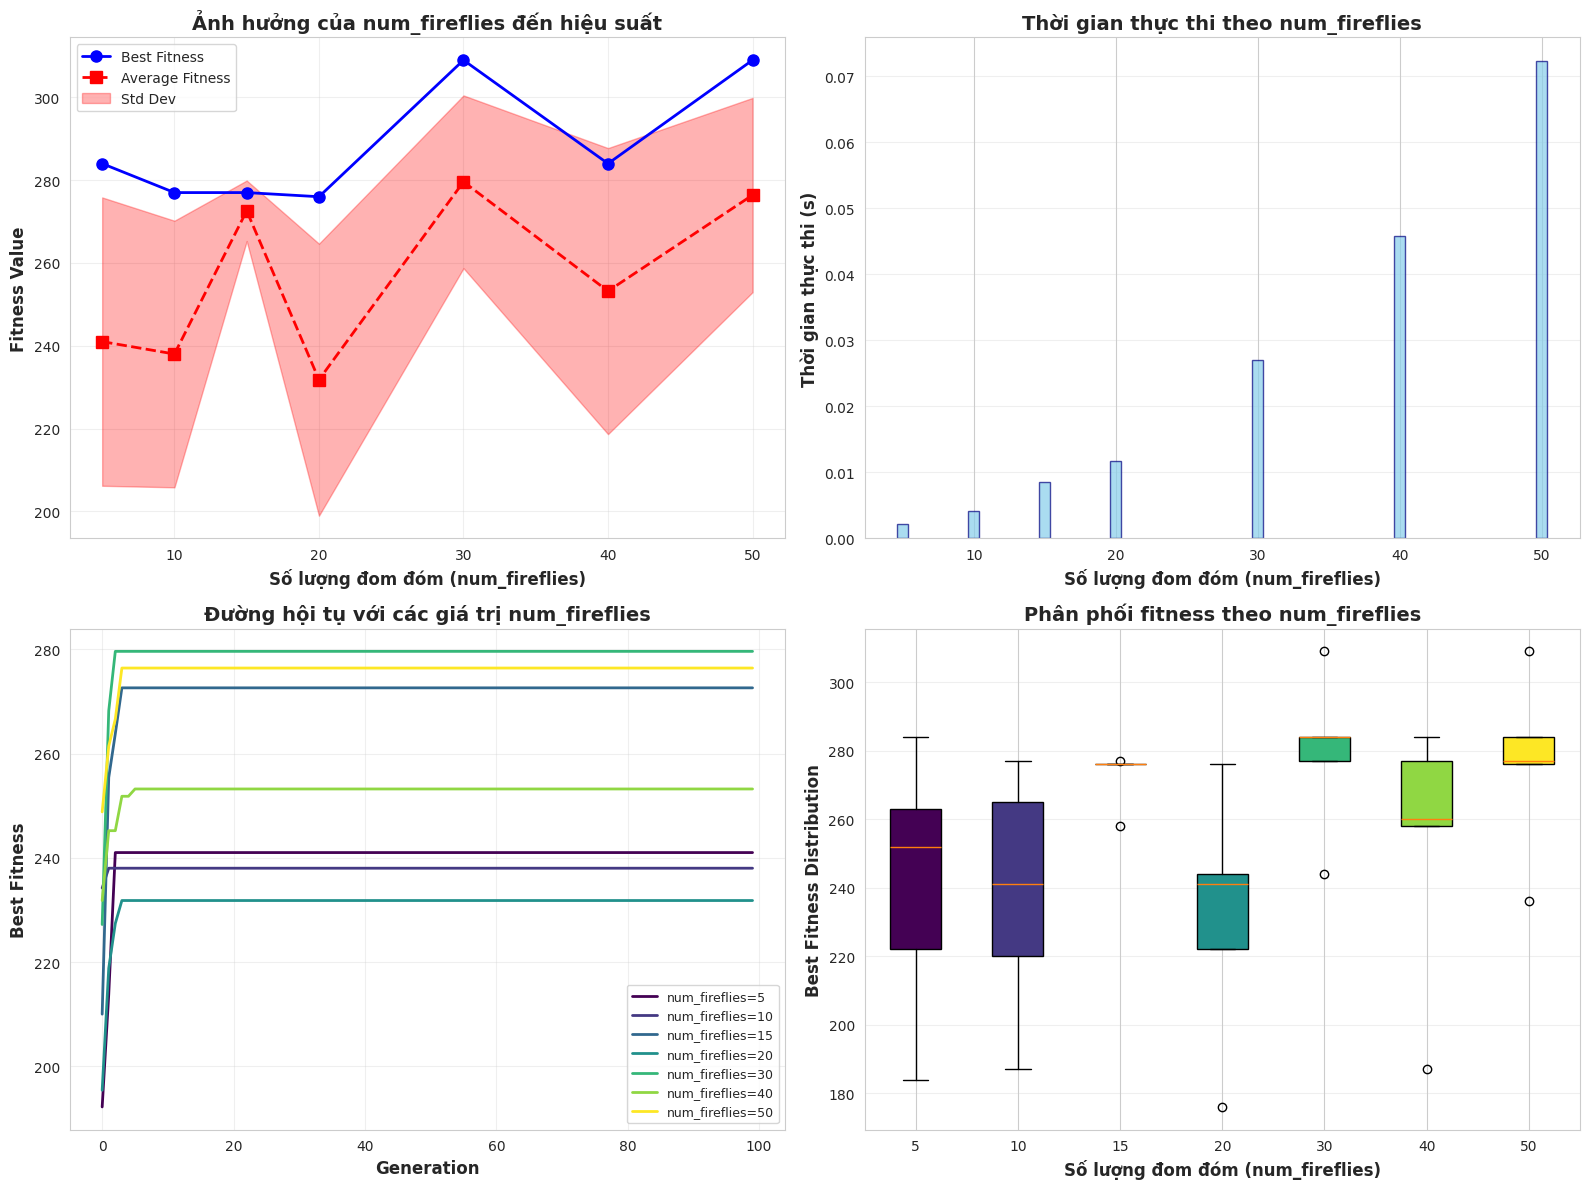

In [28]:
# Visualization cho num_fireflies
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Best Fitness vs num_fireflies
ax1 = axes[0, 0]
num_ff_vals = [r["num_fireflies"] for r in results_num_fireflies]
best_vals = [r["best_fitness"] for r in results_num_fireflies]
avg_vals = [r["avg_fitness"] for r in results_num_fireflies]
std_vals = [r["std_fitness"] for r in results_num_fireflies]

ax1.plot(num_ff_vals, best_vals, "bo-", linewidth=2, markersize=8, label="Best Fitness")
ax1.plot(
    num_ff_vals, avg_vals, "rs--", linewidth=2, markersize=8, label="Average Fitness"
)
ax1.fill_between(
    num_ff_vals,
    np.array(avg_vals) - np.array(std_vals),
    np.array(avg_vals) + np.array(std_vals),
    alpha=0.3,
    color="red",
    label="Std Dev",
)
ax1.set_xlabel("Số lượng đom đóm (num_fireflies)", fontsize=12, fontweight="bold")
ax1.set_ylabel("Fitness Value", fontsize=12, fontweight="bold")
ax1.set_title(
    "Ảnh hưởng của num_fireflies đến hiệu suất", fontsize=14, fontweight="bold"
)
ax1.legend(loc="best")
ax1.grid(True, alpha=0.3)

# 2. Execution Time vs num_fireflies
ax2 = axes[0, 1]
time_vals = [r["avg_time"] for r in results_num_fireflies]
ax2.bar(num_ff_vals, time_vals, color="skyblue", edgecolor="navy", alpha=0.7)
ax2.set_xlabel("Số lượng đom đóm (num_fireflies)", fontsize=12, fontweight="bold")
ax2.set_ylabel("Thời gian thực thi (s)", fontsize=12, fontweight="bold")
ax2.set_title("Thời gian thực thi theo num_fireflies", fontsize=14, fontweight="bold")
ax2.grid(True, alpha=0.3, axis="y")

# 3. Convergence curves for different num_fireflies
ax3 = axes[1, 0]
colors = plt.cm.viridis(np.linspace(0, 1, len(results_num_fireflies)))
for i, result in enumerate(results_num_fireflies):
    # Tính trung bình của các lần chạy
    avg_history = np.mean(result["convergence_history"], axis=0)
    ax3.plot(
        avg_history,
        color=colors[i],
        linewidth=2,
        label=f"num_fireflies={result['num_fireflies']}",
    )
ax3.set_xlabel("Generation", fontsize=12, fontweight="bold")
ax3.set_ylabel("Best Fitness", fontsize=12, fontweight="bold")
ax3.set_title(
    "Đường hội tụ với các giá trị num_fireflies", fontsize=14, fontweight="bold"
)
ax3.legend(loc="best", fontsize=9)
ax3.grid(True, alpha=0.3)

# 4. Box plot for variance analysis
ax4 = axes[1, 1]
data_for_boxplot = [r["all_best_fitnesses"] for r in results_num_fireflies]
bp = ax4.boxplot(data_for_boxplot, labels=num_ff_vals, patch_artist=True)
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
ax4.set_xlabel("Số lượng đom đóm (num_fireflies)", fontsize=12, fontweight="bold")
ax4.set_ylabel("Best Fitness Distribution", fontsize=12, fontweight="bold")
ax4.set_title("Phân phối fitness theo num_fireflies", fontsize=14, fontweight="bold")
ax4.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

## 2. Phân tích độ nhạy của tham số `beta` (Attractiveness Coefficient)

In [29]:
# Test với các giá trị khác nhau của beta
beta_values = [0.1, 0.3, 0.5, 0.7, 1.0, 1.5, 2.0]
results_beta = []

print("Đang test tham số beta...")
for beta in tqdm(beta_values):
    result = run_fa_knapsack(
        problem_num=problem_num,
        num_fireflies=20,
        beta=beta,
        gamma=1.0,
        alpha=0.2,
        max_generations=max_generations,
        num_runs=num_runs,
    )
    result["beta"] = beta
    results_beta.append(result)
    print(
        f"beta={beta}: Best={result['best_fitness']:.2f}, Avg={result['avg_fitness']:.2f}"
    )

Đang test tham số beta...


 43%|████▎     | 3/7 [00:00<00:00,  8.46it/s]

beta=0.1: Best=309.00, Avg=240.80
beta=0.3: Best=309.00, Avg=279.80
beta=0.5: Best=284.00, Avg=273.60


 71%|███████▏  | 5/7 [00:00<00:00, 10.39it/s]

beta=0.7: Best=309.00, Avg=244.80
beta=1.0: Best=277.00, Avg=263.60
beta=1.5: Best=270.00, Avg=236.20


100%|██████████| 7/7 [00:00<00:00,  9.45it/s]

beta=2.0: Best=284.00, Avg=251.40


/tmp/ipykernel_59693/3281546011.py:44: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(data_for_boxplot, labels=beta_vals, patch_artist=True)


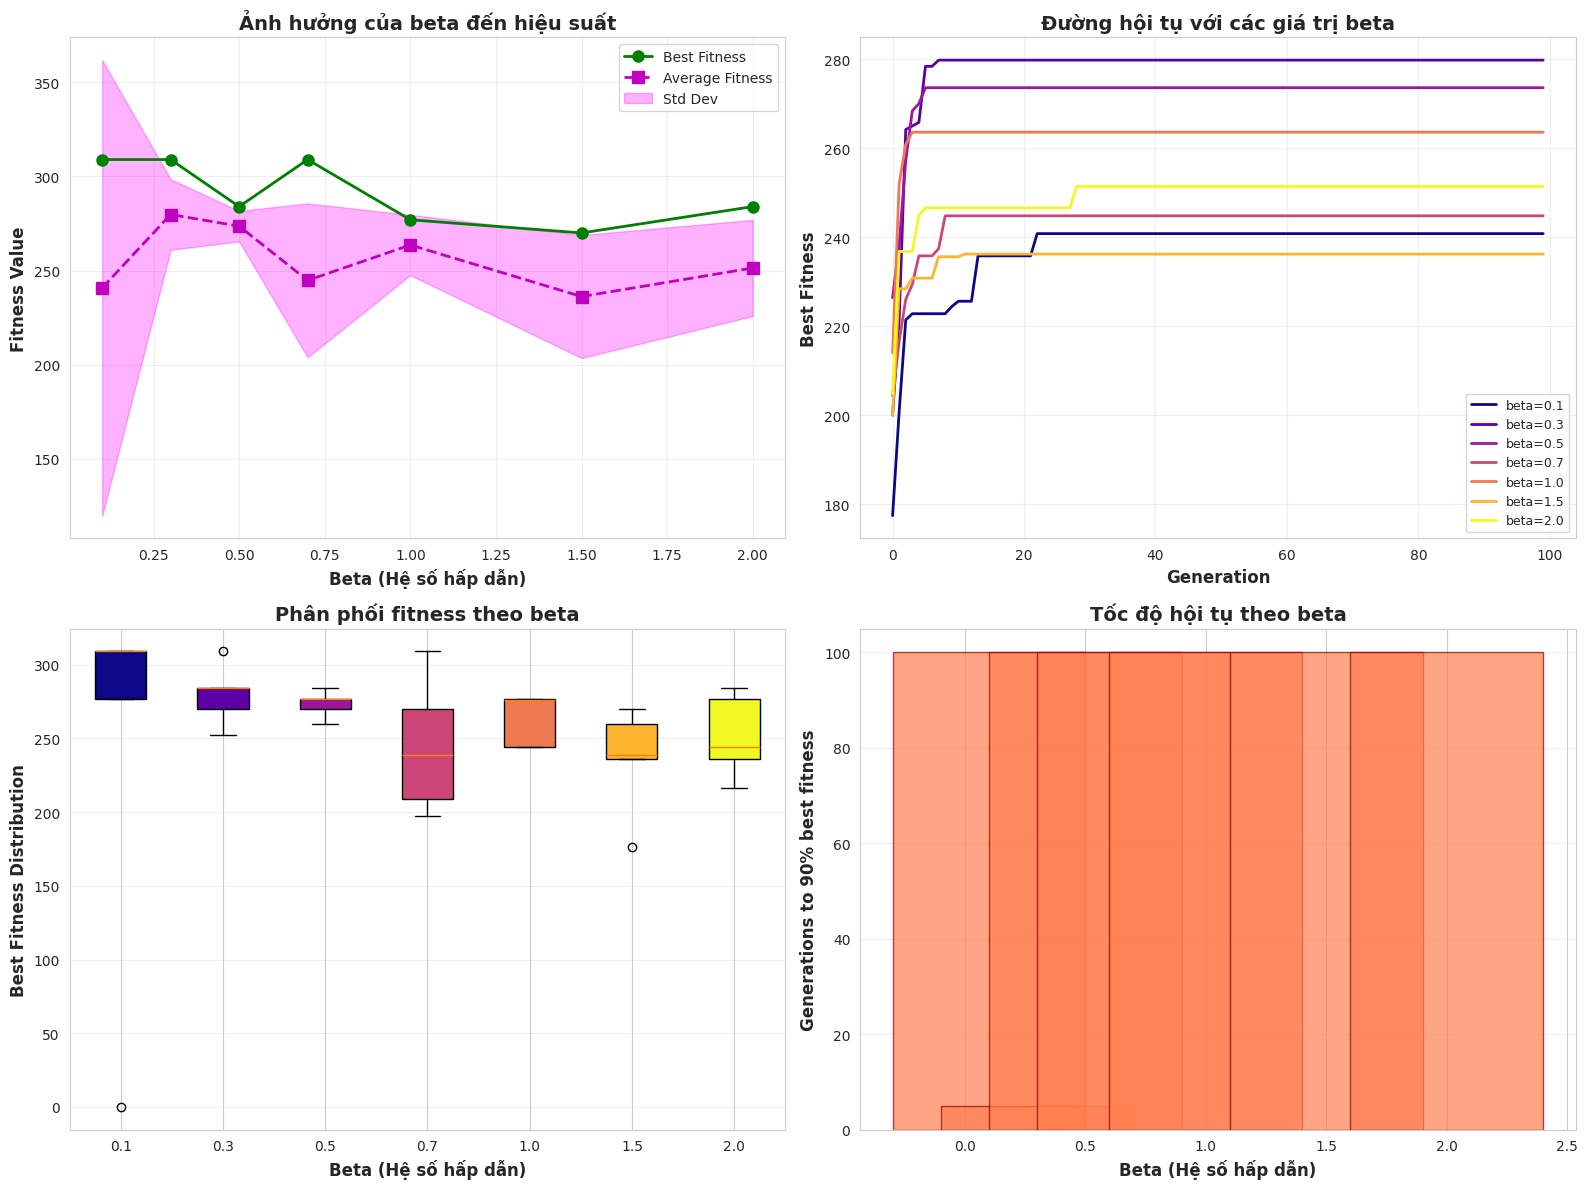

In [30]:
# Visualization cho beta
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Best Fitness vs beta
ax1 = axes[0, 0]
beta_vals = [r["beta"] for r in results_beta]
best_vals = [r["best_fitness"] for r in results_beta]
avg_vals = [r["avg_fitness"] for r in results_beta]
std_vals = [r["std_fitness"] for r in results_beta]

ax1.plot(beta_vals, best_vals, "go-", linewidth=2, markersize=8, label="Best Fitness")
ax1.plot(
    beta_vals, avg_vals, "ms--", linewidth=2, markersize=8, label="Average Fitness"
)
ax1.fill_between(
    beta_vals,
    np.array(avg_vals) - np.array(std_vals),
    np.array(avg_vals) + np.array(std_vals),
    alpha=0.3,
    color="magenta",
    label="Std Dev",
)
ax1.set_xlabel("Beta (Hệ số hấp dẫn)", fontsize=12, fontweight="bold")
ax1.set_ylabel("Fitness Value", fontsize=12, fontweight="bold")
ax1.set_title("Ảnh hưởng của beta đến hiệu suất", fontsize=14, fontweight="bold")
ax1.legend(loc="best")
ax1.grid(True, alpha=0.3)

# 2. Convergence curves for different beta
ax2 = axes[0, 1]
colors = plt.cm.plasma(np.linspace(0, 1, len(results_beta)))
for i, result in enumerate(results_beta):
    avg_history = np.mean(result["convergence_history"], axis=0)
    ax2.plot(avg_history, color=colors[i], linewidth=2, label=f"beta={result['beta']}")
ax2.set_xlabel("Generation", fontsize=12, fontweight="bold")
ax2.set_ylabel("Best Fitness", fontsize=12, fontweight="bold")
ax2.set_title("Đường hội tụ với các giá trị beta", fontsize=14, fontweight="bold")
ax2.legend(loc="best", fontsize=9)
ax2.grid(True, alpha=0.3)

# 3. Box plot for variance analysis
ax3 = axes[1, 0]
data_for_boxplot = [r["all_best_fitnesses"] for r in results_beta]
bp = ax3.boxplot(data_for_boxplot, labels=beta_vals, patch_artist=True)
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
ax3.set_xlabel("Beta (Hệ số hấp dẫn)", fontsize=12, fontweight="bold")
ax3.set_ylabel("Best Fitness Distribution", fontsize=12, fontweight="bold")
ax3.set_title("Phân phối fitness theo beta", fontsize=14, fontweight="bold")
ax3.grid(True, alpha=0.3, axis="y")

# 4. Convergence speed (generations to reach threshold)
ax4 = axes[1, 1]
threshold = 0.9 * max([r["best_fitness"] for r in results_beta])
convergence_speeds = []
for result in results_beta:
    avg_history = np.mean(result["convergence_history"], axis=0)
    gen_to_threshold = (
        np.argmax(avg_history >= threshold)
        if np.any(avg_history >= threshold)
        else max_generations
    )
    convergence_speeds.append(gen_to_threshold)

ax4.bar(beta_vals, convergence_speeds, color="coral", edgecolor="darkred", alpha=0.7)
ax4.set_xlabel("Beta (Hệ số hấp dẫn)", fontsize=12, fontweight="bold")
ax4.set_ylabel("Generations to 90% best fitness", fontsize=12, fontweight="bold")
ax4.set_title("Tốc độ hội tụ theo beta", fontsize=14, fontweight="bold")
ax4.grid(True, alpha=0.3, axis="y")

plt.tight_layout()
plt.show()

## 3. Phân tích độ nhạy của tham số `gamma` (Light Absorption Coefficient)

In [31]:
# Test với các giá trị khác nhau của gamma
gamma_values = [0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
results_gamma = []

print("Đang test tham số gamma...")
for gamma in tqdm(gamma_values):
    result = run_fa_knapsack(
        problem_num=problem_num,
        num_fireflies=20,
        beta=1.0,
        gamma=gamma,
        alpha=0.2,
        max_generations=max_generations,
        num_runs=num_runs,
    )
    result["gamma"] = gamma
    results_gamma.append(result)
    print(
        f"gamma={gamma}: Best={result['best_fitness']:.2f}, Avg={result['avg_fitness']:.2f}"
    )

Đang test tham số gamma...


 29%|██▊       | 2/7 [00:00<00:00, 14.41it/s]

gamma=0.01: Best=260.00, Avg=236.40
gamma=0.1: Best=259.00, Avg=186.80
gamma=0.5: Best=270.00, Avg=255.60
gamma=0.5: Best=270.00, Avg=255.60


 57%|█████▋    | 4/7 [00:00<00:00, 13.90it/s]

gamma=1.0: Best=269.00, Avg=203.40
gamma=2.0: Best=309.00, Avg=267.20


 86%|████████▌ | 6/7 [00:00<00:00,  6.84it/s]

gamma=5.0: Best=309.00, Avg=292.60


100%|██████████| 7/7 [00:01<00:00,  5.88it/s]

gamma=10.0: Best=309.00, Avg=304.00


/tmp/ipykernel_59693/2762137269.py:48: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(


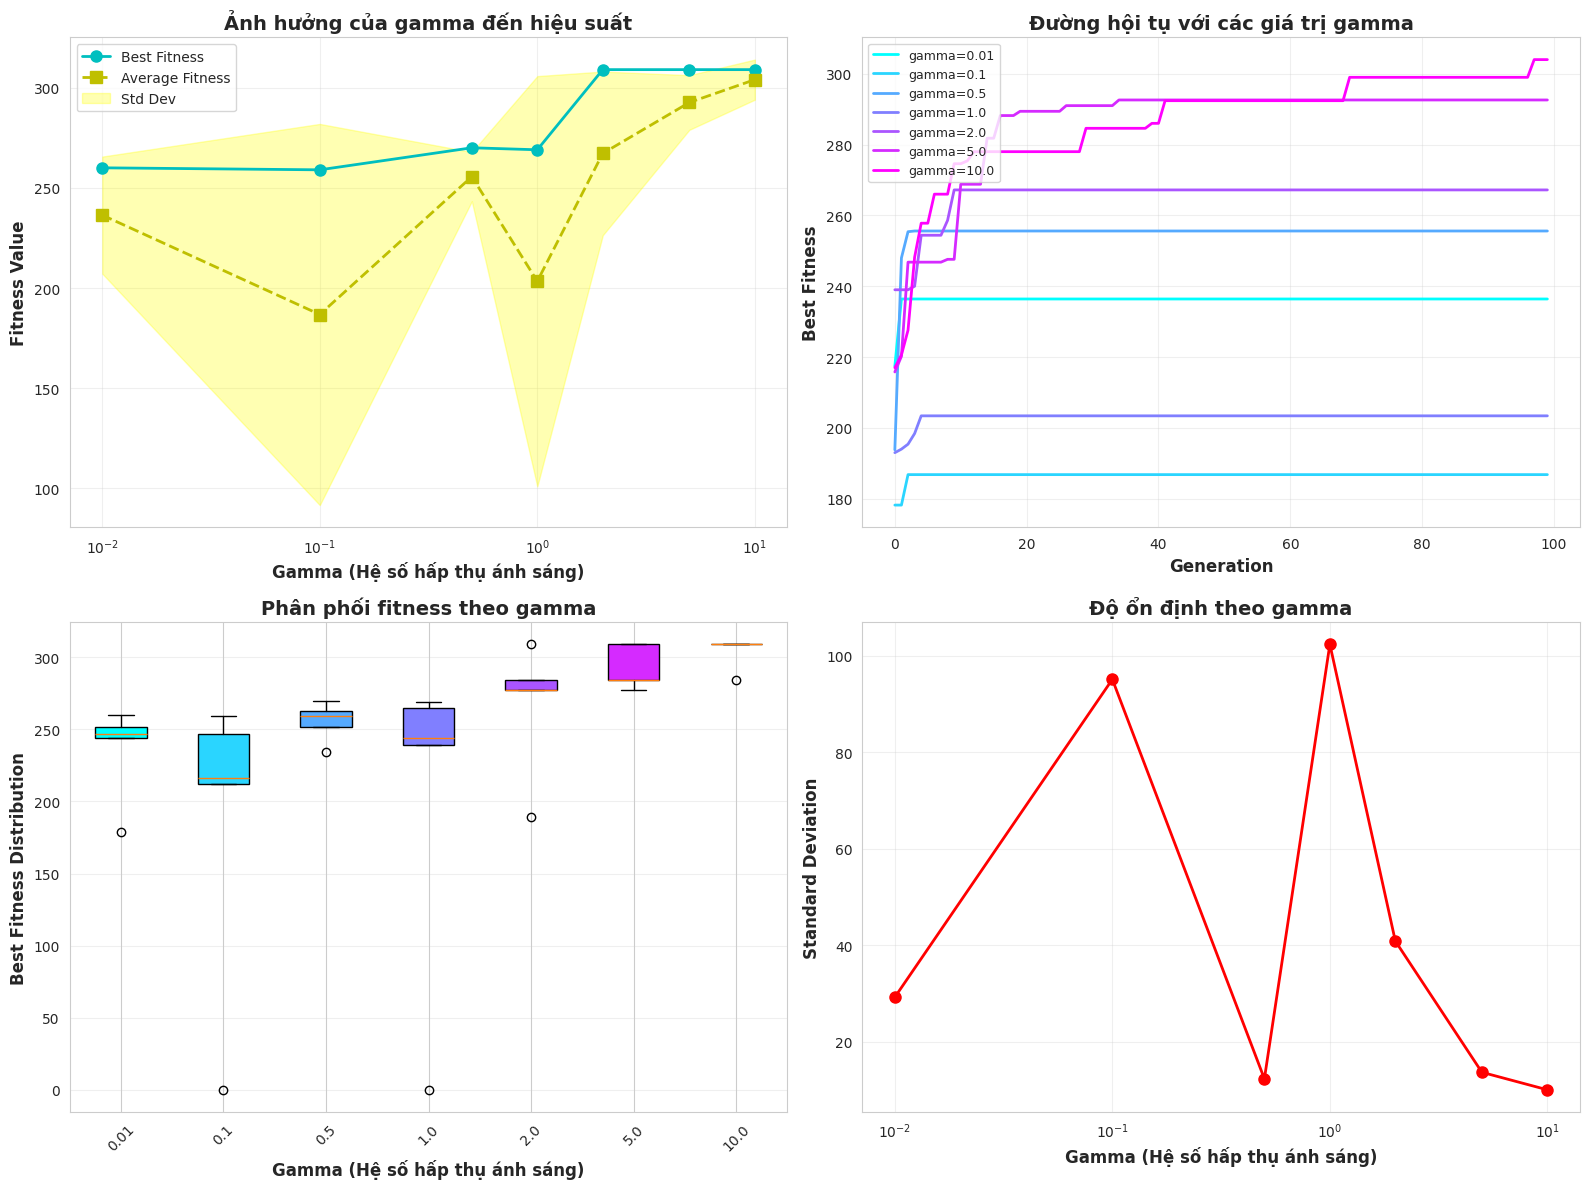

In [32]:
# Visualization cho gamma
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Best Fitness vs gamma
ax1 = axes[0, 0]
gamma_vals = [r["gamma"] for r in results_gamma]
best_vals = [r["best_fitness"] for r in results_gamma]
avg_vals = [r["avg_fitness"] for r in results_gamma]
std_vals = [r["std_fitness"] for r in results_gamma]

ax1.semilogx(
    gamma_vals, best_vals, "co-", linewidth=2, markersize=8, label="Best Fitness"
)
ax1.semilogx(
    gamma_vals, avg_vals, "ys--", linewidth=2, markersize=8, label="Average Fitness"
)
ax1.fill_between(
    gamma_vals,
    np.array(avg_vals) - np.array(std_vals),
    np.array(avg_vals) + np.array(std_vals),
    alpha=0.3,
    color="yellow",
    label="Std Dev",
)
ax1.set_xlabel("Gamma (Hệ số hấp thụ ánh sáng)", fontsize=12, fontweight="bold")
ax1.set_ylabel("Fitness Value", fontsize=12, fontweight="bold")
ax1.set_title("Ảnh hưởng của gamma đến hiệu suất", fontsize=14, fontweight="bold")
ax1.legend(loc="best")
ax1.grid(True, alpha=0.3)

# 2. Convergence curves for different gamma
ax2 = axes[0, 1]
colors = plt.cm.cool(np.linspace(0, 1, len(results_gamma)))
for i, result in enumerate(results_gamma):
    avg_history = np.mean(result["convergence_history"], axis=0)
    ax2.plot(
        avg_history, color=colors[i], linewidth=2, label=f"gamma={result['gamma']}"
    )
ax2.set_xlabel("Generation", fontsize=12, fontweight="bold")
ax2.set_ylabel("Best Fitness", fontsize=12, fontweight="bold")
ax2.set_title("Đường hội tụ với các giá trị gamma", fontsize=14, fontweight="bold")
ax2.legend(loc="best", fontsize=9)
ax2.grid(True, alpha=0.3)

# 3. Box plot for variance analysis
ax3 = axes[1, 0]
data_for_boxplot = [r["all_best_fitnesses"] for r in results_gamma]
bp = ax3.boxplot(
    data_for_boxplot, labels=[f"{g}" for g in gamma_vals], patch_artist=True
)
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
ax3.set_xlabel("Gamma (Hệ số hấp thụ ánh sáng)", fontsize=12, fontweight="bold")
ax3.set_ylabel("Best Fitness Distribution", fontsize=12, fontweight="bold")
ax3.set_title("Phân phối fitness theo gamma", fontsize=14, fontweight="bold")
ax3.grid(True, alpha=0.3, axis="y")
ax3.tick_params(axis="x", rotation=45)

# 4. Standard deviation analysis
ax4 = axes[1, 1]
ax4.plot(gamma_vals, std_vals, "ro-", linewidth=2, markersize=8)
ax4.set_xscale("log")
ax4.set_xlabel("Gamma (Hệ số hấp thụ ánh sáng)", fontsize=12, fontweight="bold")
ax4.set_ylabel("Standard Deviation", fontsize=12, fontweight="bold")
ax4.set_title("Độ ổn định theo gamma", fontsize=14, fontweight="bold")
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Phân tích độ nhạy của tham số `alpha` (Randomization Parameter)

In [33]:
# Test với các giá trị khác nhau của alpha
alpha_values = [0.05, 0.1, 0.2, 0.3, 0.5, 0.7, 1.0]
results_alpha = []

print("Đang test tham số alpha...")
for alpha in tqdm(alpha_values):
    result = run_fa_knapsack(
        problem_num=problem_num,
        num_fireflies=20,
        beta=1.0,
        gamma=1.0,
        alpha=alpha,
        max_generations=max_generations,
        num_runs=num_runs,
    )
    result["alpha"] = alpha
    results_alpha.append(result)
    print(
        f"alpha={alpha}: Best={result['best_fitness']:.2f}, Avg={result['avg_fitness']:.2f}"
    )

Đang test tham số alpha...


 29%|██▊       | 2/7 [00:00<00:00, 12.32it/s]

alpha=0.05: Best=270.00, Avg=239.80
alpha=0.1: Best=309.00, Avg=273.00
alpha=0.2: Best=284.00, Avg=208.40
alpha=0.2: Best=284.00, Avg=208.40


 57%|█████▋    | 4/7 [00:00<00:00, 11.99it/s]

alpha=0.3: Best=309.00, Avg=194.80
alpha=0.5: Best=309.00, Avg=230.80
alpha=0.5: Best=309.00, Avg=230.80


 86%|████████▌ | 6/7 [00:00<00:00,  7.82it/s]

alpha=0.7: Best=309.00, Avg=296.20


100%|██████████| 7/7 [00:01<00:00,  6.09it/s]

alpha=1.0: Best=309.00, Avg=299.00


/tmp/ipykernel_59693/2405239621.py:46: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(data_for_boxplot, labels=alpha_vals, patch_artist=True)


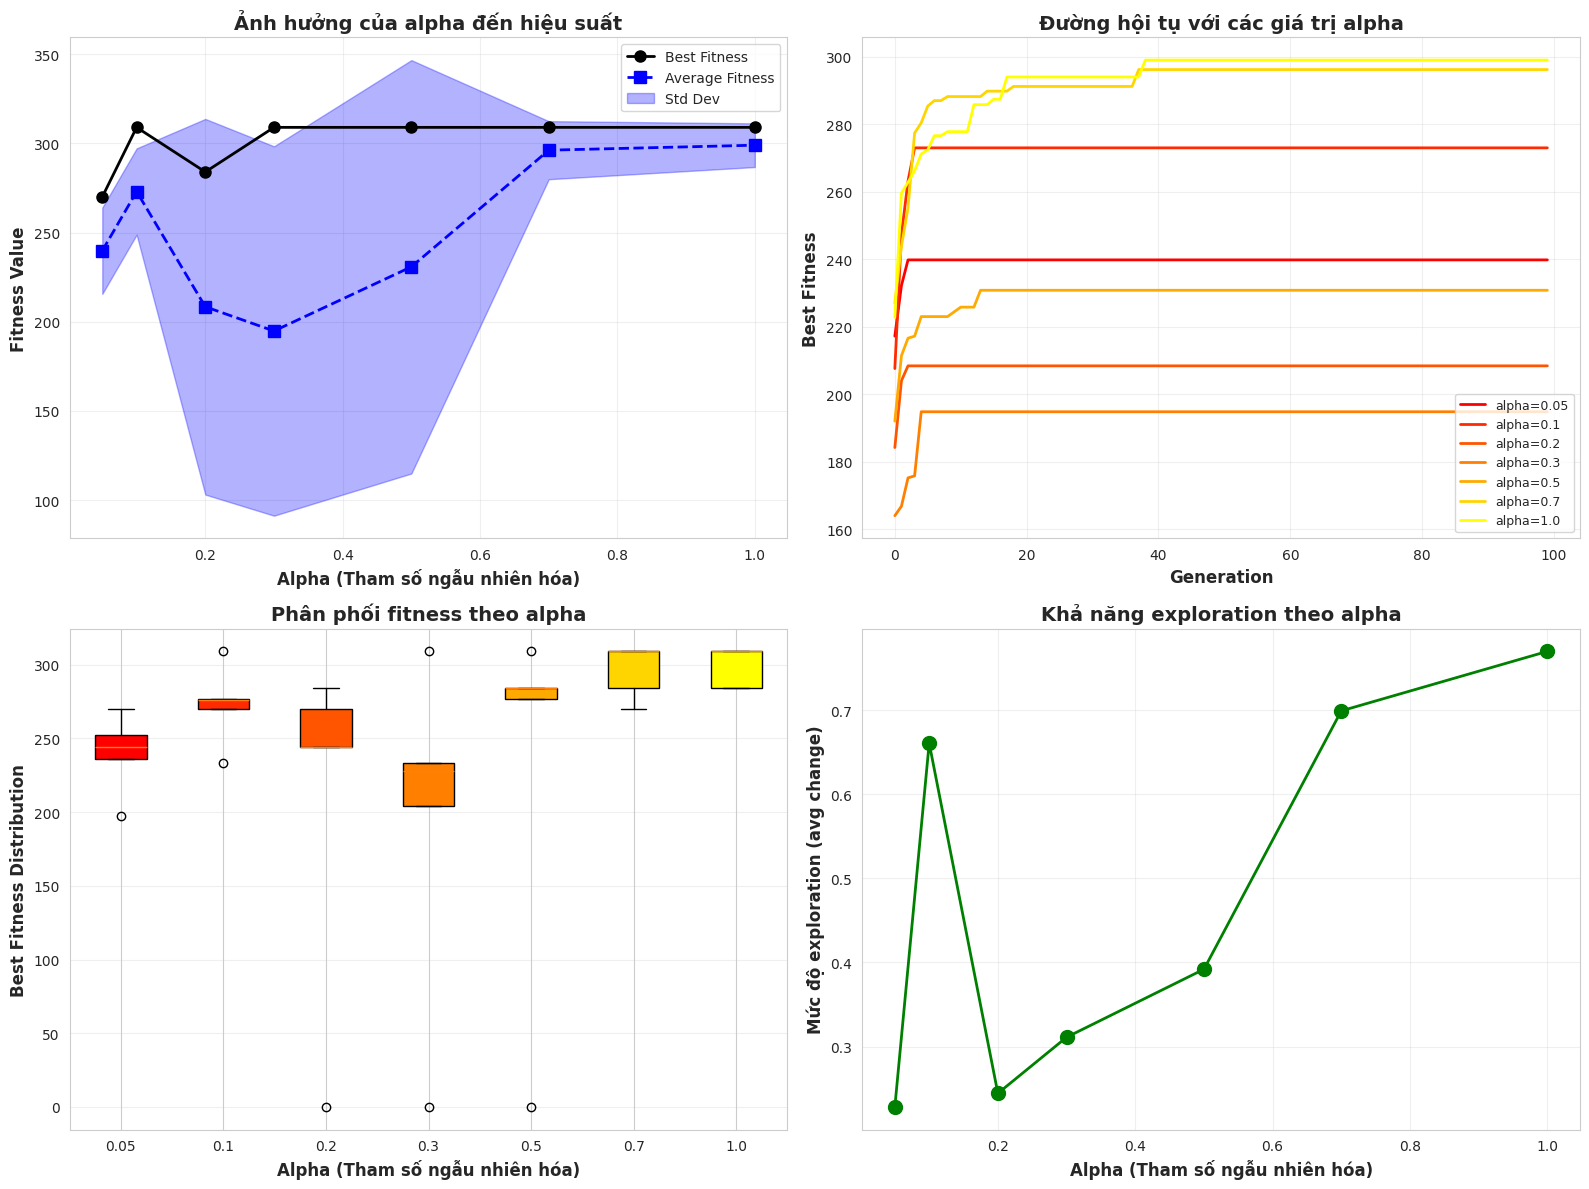

In [34]:
# Visualization cho alpha
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Best Fitness vs alpha
ax1 = axes[0, 0]
alpha_vals = [r["alpha"] for r in results_alpha]
best_vals = [r["best_fitness"] for r in results_alpha]
avg_vals = [r["avg_fitness"] for r in results_alpha]
std_vals = [r["std_fitness"] for r in results_alpha]

ax1.plot(alpha_vals, best_vals, "ko-", linewidth=2, markersize=8, label="Best Fitness")
ax1.plot(
    alpha_vals, avg_vals, "bs--", linewidth=2, markersize=8, label="Average Fitness"
)
ax1.fill_between(
    alpha_vals,
    np.array(avg_vals) - np.array(std_vals),
    np.array(avg_vals) + np.array(std_vals),
    alpha=0.3,
    color="blue",
    label="Std Dev",
)
ax1.set_xlabel("Alpha (Tham số ngẫu nhiên hóa)", fontsize=12, fontweight="bold")
ax1.set_ylabel("Fitness Value", fontsize=12, fontweight="bold")
ax1.set_title("Ảnh hưởng của alpha đến hiệu suất", fontsize=14, fontweight="bold")
ax1.legend(loc="best")
ax1.grid(True, alpha=0.3)

# 2. Convergence curves for different alpha
ax2 = axes[0, 1]
colors = plt.cm.autumn(np.linspace(0, 1, len(results_alpha)))
for i, result in enumerate(results_alpha):
    avg_history = np.mean(result["convergence_history"], axis=0)
    ax2.plot(
        avg_history, color=colors[i], linewidth=2, label=f"alpha={result['alpha']}"
    )
ax2.set_xlabel("Generation", fontsize=12, fontweight="bold")
ax2.set_ylabel("Best Fitness", fontsize=12, fontweight="bold")
ax2.set_title("Đường hội tụ với các giá trị alpha", fontsize=14, fontweight="bold")
ax2.legend(loc="best", fontsize=9)
ax2.grid(True, alpha=0.3)

# 3. Box plot for variance analysis
ax3 = axes[1, 0]
data_for_boxplot = [r["all_best_fitnesses"] for r in results_alpha]
bp = ax3.boxplot(data_for_boxplot, labels=alpha_vals, patch_artist=True)
for patch, color in zip(bp["boxes"], colors):
    patch.set_facecolor(color)
ax3.set_xlabel("Alpha (Tham số ngẫu nhiên hóa)", fontsize=12, fontweight="bold")
ax3.set_ylabel("Best Fitness Distribution", fontsize=12, fontweight="bold")
ax3.set_title("Phân phối fitness theo alpha", fontsize=14, fontweight="bold")
ax3.grid(True, alpha=0.3, axis="y")

# 4. Exploration vs Exploitation trade-off
ax4 = axes[1, 1]
# Tính độ thay đổi trung bình của fitness qua các thế hệ (đo lường exploration)
exploration_metric = []
for result in results_alpha:
    avg_history = np.mean(result["convergence_history"], axis=0)
    # Tính tổng sự thay đổi tuyệt đối
    changes = np.abs(np.diff(avg_history))
    exploration_metric.append(np.mean(changes))

ax4.plot(alpha_vals, exploration_metric, "go-", linewidth=2, markersize=10)
ax4.set_xlabel("Alpha (Tham số ngẫu nhiên hóa)", fontsize=12, fontweight="bold")
ax4.set_ylabel("Mức độ exploration (avg change)", fontsize=12, fontweight="bold")
ax4.set_title("Khả năng exploration theo alpha", fontsize=14, fontweight="bold")
ax4.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 5. Phân tích tổng hợp (Heatmap) - Tương tác giữa các tham số

In [35]:
# Phân tích tương tác giữa beta và gamma
beta_test = [0.3, 0.7, 1.0, 1.5, 2.0]
gamma_test = [0.1, 0.5, 1.0, 2.0, 5.0]

heatmap_data = np.zeros((len(beta_test), len(gamma_test)))

print("Đang test tương tác beta-gamma...")
for i, beta in enumerate(tqdm(beta_test)):
    for j, gamma in enumerate(gamma_test):
        result = run_fa_knapsack(
            problem_num=problem_num,
            num_fireflies=20,
            beta=beta,
            gamma=gamma,
            alpha=0.2,
            max_generations=max_generations,
            num_runs=3,  # Giảm số lần chạy để tăng tốc
        )
        heatmap_data[i, j] = result["avg_fitness"]
        print(f"beta={beta}, gamma={gamma}: Avg={result['avg_fitness']:.2f}")

Đang test tương tác beta-gamma...


  0%|          | 0/5 [00:00<?, ?it/s]

beta=0.3, gamma=0.1: Avg=269.67
beta=0.3, gamma=0.5: Avg=168.00
beta=0.3, gamma=1.0: Avg=184.67
beta=0.3, gamma=2.0: Avg=292.67
beta=0.3, gamma=2.0: Avg=292.67


 20%|██        | 1/5 [00:00<00:01,  2.15it/s]

beta=0.3, gamma=5.0: Avg=285.33
beta=0.7, gamma=0.1: Avg=213.33
beta=0.7, gamma=0.5: Avg=257.67
beta=0.7, gamma=1.0: Avg=171.00
beta=0.7, gamma=2.0: Avg=300.67


 40%|████      | 2/5 [00:00<00:01,  2.19it/s]

beta=0.7, gamma=5.0: Avg=309.00
beta=1.0, gamma=0.1: Avg=259.00
beta=1.0, gamma=0.5: Avg=260.33
beta=1.0, gamma=1.0: Avg=275.00
beta=1.0, gamma=2.0: Avg=273.67


 60%|██████    | 3/5 [00:01<00:00,  2.48it/s]

beta=1.0, gamma=5.0: Avg=279.00
beta=1.5, gamma=0.1: Avg=278.67
beta=1.5, gamma=0.5: Avg=224.67
beta=1.5, gamma=1.0: Avg=149.33
beta=1.5, gamma=2.0: Avg=208.67


 80%|████████  | 4/5 [00:01<00:00,  2.50it/s]

beta=1.5, gamma=5.0: Avg=286.00
beta=2.0, gamma=0.1: Avg=246.00
beta=2.0, gamma=0.5: Avg=249.33
beta=2.0, gamma=1.0: Avg=230.33
beta=2.0, gamma=2.0: Avg=285.33
beta=2.0, gamma=0.5: Avg=249.33
beta=2.0, gamma=1.0: Avg=230.33
beta=2.0, gamma=2.0: Avg=285.33


100%|██████████| 5/5 [00:02<00:00,  2.33it/s]

beta=2.0, gamma=5.0: Avg=309.00


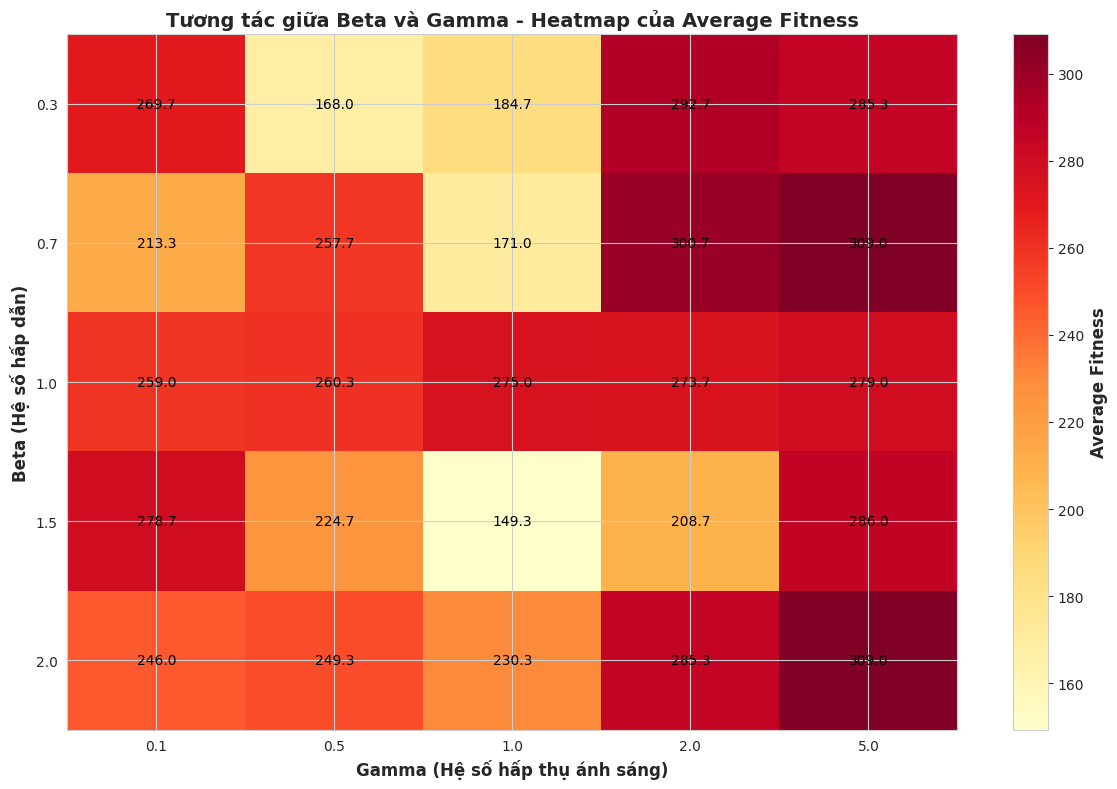

In [36]:
# Visualization heatmap cho tương tác beta-gamma
fig, ax = plt.subplots(figsize=(12, 8))

im = ax.imshow(heatmap_data, cmap="YlOrRd", aspect="auto")

# Thiết lập ticks và labels
ax.set_xticks(np.arange(len(gamma_test)))
ax.set_yticks(np.arange(len(beta_test)))
ax.set_xticklabels(gamma_test)
ax.set_yticklabels(beta_test)

# Thêm colorbar
cbar = plt.colorbar(im, ax=ax)
cbar.set_label("Average Fitness", fontsize=12, fontweight="bold")

# Thêm annotations
for i in range(len(beta_test)):
    for j in range(len(gamma_test)):
        text = ax.text(
            j,
            i,
            f"{heatmap_data[i, j]:.1f}",
            ha="center",
            va="center",
            color="black",
            fontsize=10,
        )

ax.set_xlabel("Gamma (Hệ số hấp thụ ánh sáng)", fontsize=12, fontweight="bold")
ax.set_ylabel("Beta (Hệ số hấp dẫn)", fontsize=12, fontweight="bold")
ax.set_title(
    "Tương tác giữa Beta và Gamma - Heatmap của Average Fitness",
    fontsize=14,
    fontweight="bold",
)

plt.tight_layout()
plt.show()